# PMLDL Homework 1
Completed by Alla Chepurova, BS18-DS-01, a.chepurova@innopolis.university

## Libs

In [100]:
import warnings
import os
import torch
import time
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, Sampler
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers, losses, distances
from annoy import AnnoyIndex
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
warnings.filterwarnings('ignore')

## Datasets preparation

In [2]:
data_dir = "Inshop-data"

In [3]:
input_size = 224
batch_size = 32
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = "cuda"

In [4]:
def get_labels(dataset):
    labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i][1])
    return np.array(labels)
        
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=data_transforms['train'])
gallery_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'gallery'), transform=data_transforms['val'])
query_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'query'), transform=data_transforms['val'])                                                 

labels = get_labels(train_dataset)

In [5]:
num_classes = len(np.unique(labels))

In [6]:
class MPerClassSampler(Sampler):
    def __init__(self, labels, batch_size, m=4):
        self.labels = np.array(labels)
        self.labels_unique = np.unique(labels)
        self.batch_size = batch_size
        self.m = m
        assert batch_size % m == 0, 'batch size must be divided by m'

    def __len__(self):
        return len(self.labels) // self.batch_size

    def __iter__(self):
        for _ in range(self.__len__()):
            labels_in_batch = set()
            inds = np.array([], dtype=int)

            while inds.shape[0] < self.batch_size:
                sample_label = np.random.choice(self.labels_unique)
                if sample_label in labels_in_batch:
                    continue
                labels_in_batch.add(sample_label)
                sample_label_ids = np.argwhere(np.in1d(self.labels, sample_label)).reshape(-1)
                subsample = np.random.permutation(sample_label_ids)
                
                #print(subsample)
                for i in range(self.m):
                    inds = np.append(inds, subsample[i % len(subsample)])
            
            inds = inds[:self.batch_size]
            
            inds = np.random.permutation(inds)

            return iter(list(inds))

sampler = samplers.MPerClassSampler(labels, 4, batch_size=batch_size)
#sampler = MPerClassSampler(labels, 64)

train_dataloader = DataLoader(train_dataset, batch_size, sampler=sampler)
gallery_dataloader = DataLoader(gallery_dataset, batch_size)
query_dataloader = DataLoader(query_dataset, batch_size)    

## Backbone model preparation

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True


model_ft = models.resnet50(pretrained=True).to("cuda")
model_ft.fc = Identity()
set_parameter_requires_grad(model_ft)
model_ft.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Test metric class

In [8]:
class RecallMetric(object):
    def __init__(self, feats, labels):

        self.is_equal_query = False
        self.gallery_feats, self.query_feats = feats
        self.gallery_labels, self.query_labels = labels
        self.sim_mat = np.matmul(self.query_feats, np.transpose(self.gallery_feats))

    def recall_at_k(self, k=1):
        m = len(self.sim_mat)
        match_counter = 0
        for i in range(m):
            pos_sim = self.sim_mat[i][self.gallery_labels == self.query_labels[i]]
            neg_sim = self.sim_mat[i][self.gallery_labels != self.query_labels[i]]
            thresh = np.sort(pos_sim)[-2] if self.is_equal_query else np.max(pos_sim)
            if np.sum(neg_sim > thresh) < k:
                match_counter += 1
        return float(match_counter) / m

## Pytorch Lightning model class

In [9]:
class TwoLossModel(pl.LightningModule):

    def __init__(self, num_classes, embedding_size):
        super().__init__()
        self.res_net = model_ft
        self.loss = self.Loss(num_classes, embedding_size)
        self.clas = torch.nn.Linear(2048, 1024)

    def forward(self, inp):
        hidden = self.res_net(inp)
        norm = torch.nn.LayerNorm(hidden.size()[1:], elementwise_affine=False)
        normed = norm(hidden)
        out = self.clas(normed)
        out = torch.nn.functional.normalize(out, dim=1)
        return out

    def Loss(self, num_classes, embedding_size):
        main_loss = losses.AngularLoss(alpha=40)
        var_loss = losses.NormalizedSoftmaxLoss(num_classes, 
                            embedding_size)
        complete_loss = losses.MultipleLosses([main_loss, var_loss], weights=[1, 0.5])
        return complete_loss
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch[0]
        y = train_batch[1]
        v = self.forward(x)
        loss = self.loss(v, y)
        self.log('train_loss', loss)
        return {"loss": loss}
    
    def validation_step(self, val_batch, batch_idx):
        x = val_batch[0]
        y = val_batch[1]
        v = self.forward(x)
        loss = self.loss(v, y)
        self.log('val_loss', loss, prog_bar=True)
        return {"val_loss": loss}

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=3e-4, momentum=0.9)
        reduce_lr_on_plateau = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.2,
            patience=2,
            min_lr=1e-6,
            verbose=True), 
            'monitor': 'val_loss'
        }

        return [optimizer], [reduce_lr_on_plateau]
    
    def validation_epoch_end(self, outs):
        feat_query = []
        labels_query = []

        model_ft.to(device)
        for batch in iter(query_dataloader):
            with torch.no_grad():
                feat_query.append(self.forward(batch[0].to(device)))
                torch.cuda.empty_cache()
                labels_query.append(batch[1])

        feat_query = torch.cat(feat_query, 0).cpu().numpy()
        labels_query = torch.cat(labels_query, 0).cpu().numpy()

        feat_gallery = []
        labels_gallery = []

        for batch in iter(gallery_dataloader):
            with torch.no_grad():
                feat_gallery.append(self.forward(batch[0].to(device)))
                torch.cuda.empty_cache()
                labels_gallery.append(batch[1])

        feat_gallery = torch.cat(feat_gallery, 0).cpu().numpy()
        labels_gallery = torch.cat(labels_gallery, 0).cpu().numpy()

        recall_metric = RecallMetric((feat_gallery, feat_query), (labels_gallery, labels_query))
        
        self.log("R@1", recall_metric.recall_at_k(1))
        self.log("R@5", recall_metric.recall_at_k(5))
        self.log("R@10", recall_metric.recall_at_k(10))


In [10]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./callback_logs",
    filename="two_losses_model",
    save_top_k=1,
    mode="min",
)

tb_logger = pl_loggers.TensorBoardLogger("./logs/", default_hp_metric=False)
embedding_size = 1024
model = TwoLossModel(num_classes, embedding_size)
trainer = pl.Trainer(gpus=AVAIL_GPUS,
    max_epochs=20, logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [11]:
trainer.fit(model, train_dataloader, gallery_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: ./logs/default

  | Name    | Type           | Params
-------------------------------------------
0 | res_net | ResNet         | 23.5 M
1 | loss    | MultipleLosses | 4.1 M 
2 | clas    | Linear         | 2.1 M 
-------------------------------------------
29.7 M    Trainable params
0         Non-trainable params
29.7 M    Total params
118.797   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/alla/env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/alla/env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    14: reducing learning rate of group 0 to 6.0000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    17: reducing learning rate of group 0 to 1.2000e-05.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    20: reducing learning rate of group 0 to 2.4000e-06.


In [12]:
PATH = "./model_2_loss"
torch.save(model_ft.state_dict(), PATH)

In [13]:
model.eval()
model.to("cuda")

TwoLossModel(
  (res_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [14]:
feat_query = []
labels_query = []

model_ft.to(device)
for batch in iter(query_dataloader):
    with torch.no_grad():
        feat_query.append(model.forward(batch[0].to(device)))
        torch.cuda.empty_cache()
        labels_query.append(batch[1])

feat_query = torch.cat(feat_query, 0).cpu().numpy()
labels_query = torch.cat(labels_query, 0).cpu().numpy()

feat_gallery = []
labels_gallery = []

for batch in iter(gallery_dataloader):
    with torch.no_grad():
        feat_gallery.append(model.forward(batch[0].to(device)))
        torch.cuda.empty_cache()
        labels_gallery.append(batch[1])

feat_gallery = torch.cat(feat_gallery, 0).cpu().numpy()
labels_gallery = torch.cat(labels_gallery, 0).cpu().numpy()

recall_metric = RecallMetric((feat_gallery, feat_query), (labels_gallery, labels_query))

In [15]:
print("recall at 1", recall_metric.recall_at_k(1))
print("recall at 5", recall_metric.recall_at_k(5))
print("recall at 10", recall_metric.recall_at_k(10))

recall at 1 0.8136868757912505
recall at 5 0.9103249402166268
recall at 10 0.9332536221690815


## Metrics report

In [163]:
from IPython.display import Image

## R@1

In [172]:
Image(url='https://raw.githubusercontent.com/screemix/practical-deep-learning/main/metric_res/r1.png')

## R@5

In [174]:
Image(url='https://raw.githubusercontent.com/screemix/practical-deep-learning/main/metric_res/r5.png')

## R@10

In [175]:
Image(url='https://raw.githubusercontent.com/screemix/practical-deep-learning/main/metric_res/r10.png')

## Train Loss

In [177]:
Image(url='https://raw.githubusercontent.com/screemix/practical-deep-learning/main/metric_res/train.png')

## Validation loss

In [178]:
Image(url='https://raw.githubusercontent.com/screemix/practical-deep-learning/main/metric_res/val.png')

## Visualization

In [124]:
def show(img):
    npimg = [i.numpy() for i in img]
    fig = plt.figure(figsize=(25, 10))
    columns = len(img)
    rows = 1
    for i in range(1, len(img)+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.transpose(npimg[i-1], (1, 2, 0)), interpolation='nearest')
    plt.show()

In [125]:
t = AnnoyIndex(embedding_size, 'angular')
for i, v in enumerate(feat_gallery):
    t.add_item(i, v)

t.build(10)

True

In [126]:
t.save('gallery_image_retrieval.ann')

True

In [138]:
def vis():
    i = np.random.randint(0, len(feat_query), 1)[0]
    emb = t.get_nns_by_vector(feat_query[i], 5)
    labels = [labels_gallery[label] for label in emb]
    print("original label is {}, first 5 labels of neighbours are {}".format(labels_query[i], labels))
    print()
    print("Orignal image:")
    show([query_dataset[i][0]])
    print("Top 5 similar images:")
    pics = []
    for e in emb:
        pics.append(gallery_dataset[e][0])
    show(pics)
    print()
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original label is 559, first 5 labels of neighbours are [559, 559, 2592, 2592, 2592]

Orignal image:


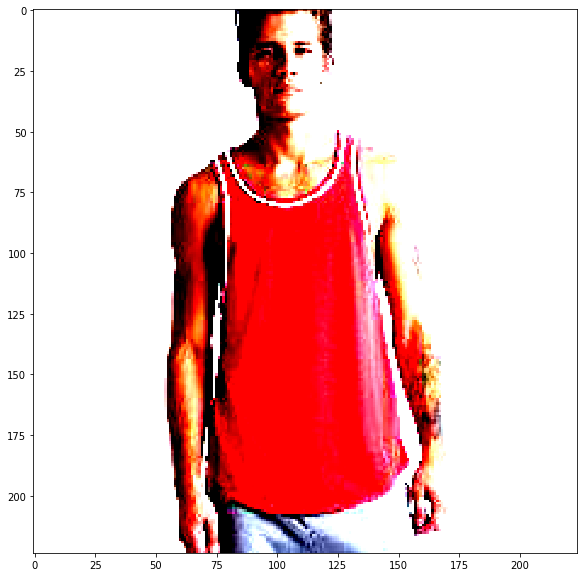

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 5 similar images:


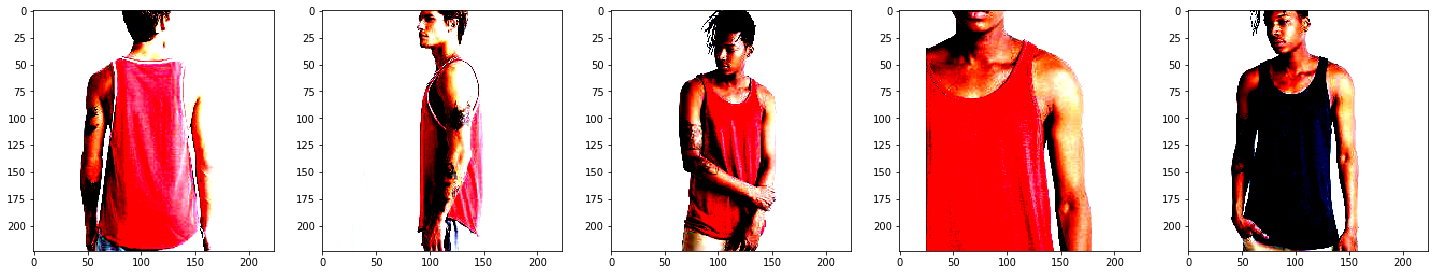

In [143]:
vis()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original label is 1287, first 5 labels of neighbours are [1287, 1287, 1287, 1190, 1775]

Orignal image:


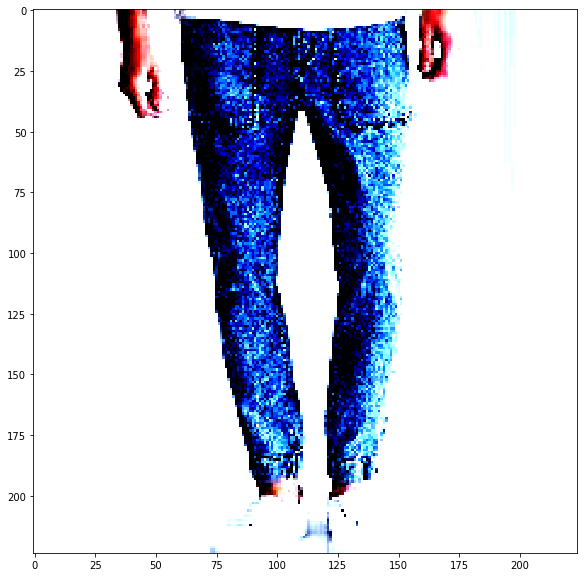

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 5 similar images:


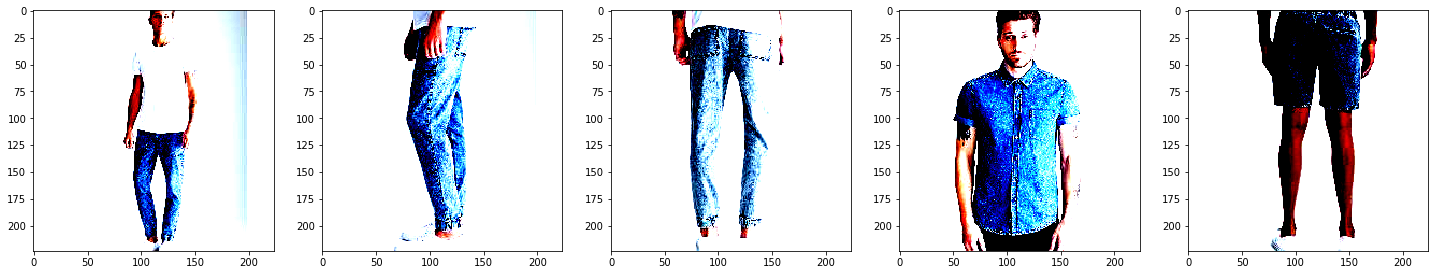

In [145]:
vis()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original label is 561, first 5 labels of neighbours are [561, 561, 2881, 2881, 2458]

Orignal image:


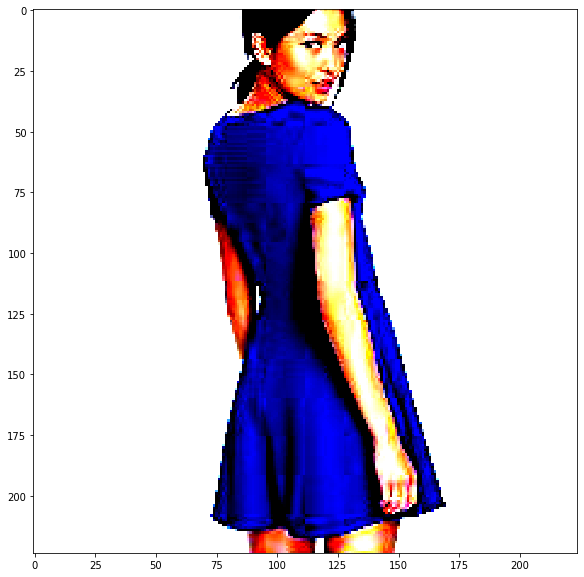

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top 5 similar images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


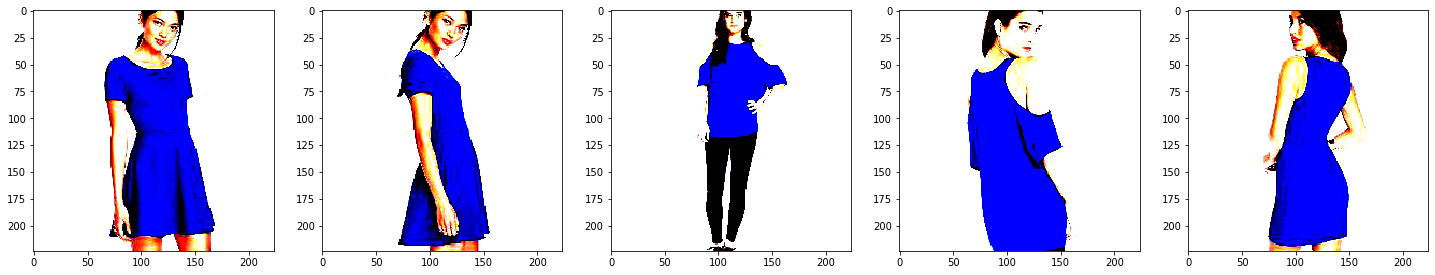

In [146]:
vis()